### Imports

In [29]:
import pandas as pd
import os
from pathlib import Path
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import scipy.stats as st
import sys
import time

CURRENT_DIR = Path(os.getcwd())
# Move to the root directory
ROOT_DIR = CURRENT_DIR.parents[0]  # Adjust the number based on your folder structure

# Add the root directory to the system path
sys.path.append(str(ROOT_DIR))

# Import the importlib module
import importlib

# import function implementations
import stst_urls

# Reload the modules
importlib.reload(stst_urls)

# Re-import the functions
from stst_urls import GTX_URL

# Input Raw File and Decoder File

In [36]:
wafer_codes = [
    "QCHZZ",
]  # List of wafer codes

ANALYSIS_RUN_NAME = "debug"

DECODER_FILE = "QC WAFER_LAYOUT 24Dec.csv"
DECODER_FILE_PATH = ROOT_DIR / "decoders" / DECODER_FILE
RESULTS_FILE_PATH = ROOT_DIR / "results"

warnings.filterwarnings("ignore")


def liv_raw_filelink_finder(wafer_codes, fileserver_link: str, product_code="QC"):
    # Add the product code to the end of the fileserver link
    fileserver_link = f"{fileserver_link}{product_code}/"
    print(f"fileserver link: {fileserver_link}")

    # Fetch the directory listing
    response = requests.get(fileserver_link, verify=False)
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all links in the directory listing
    links = soup.find_all("a")

    # Filter the links to find subdirectories that match the wafer codes
    subdirectory_urls = []
    for link in links:
        href = link.get("href")
        if href and any(wafer_code in href for wafer_code in wafer_codes):
            subdirectory_urls.append(fileserver_link + href)

    # Initialize lists for different types of files and a dictionary for machine names
    file_urls = []
    file_cod_urls = []
    file_degradation_urls = []
    machine_list = []
    machine_dict = {}

    # Iterate over wafer codes and subdirectory URLs simultaneously
    for wafer_code, subdirectory_url in zip(wafer_codes, subdirectory_urls):
        response = requests.get(subdirectory_url, verify=False)
        soup = BeautifulSoup(response.content, "html.parser")
        links = soup.find_all("a")

        latest_file = None
        latest_cod_file = None
        latest_degradation_file = None

        latest_time = ""
        latest_cod_time = ""
        latest_degradation_time = ""
        machine_name = None

        for link in links:
            href = link.get("href")
            if href and "RAW" in href:
                time_str = href[-18:-4]  # Extract the time string
                if not machine_name:
                    machine_name = href[:6]  # Extract the machine name (first 6 characters)

                if "COD250" in href:
                    if time_str > latest_cod_time:
                        latest_cod_time = time_str
                        latest_cod_file = subdirectory_url + href
                elif "COD70" in href:
                    if time_str > latest_degradation_time:
                        latest_degradation_time = time_str
                        latest_degradation_file = subdirectory_url + href
                else:
                    if time_str > latest_time:
                        latest_time = time_str
                        latest_file = subdirectory_url + href

        if latest_file:
            file_urls.append(latest_file)
        if latest_cod_file:
            file_cod_urls.append(latest_cod_file)
        if latest_degradation_file:
            file_degradation_urls.append(latest_degradation_file)
        if machine_name:
            machine_list.append(machine_name)
            machine_dict[wafer_code] = machine_name

    return file_urls, file_cod_urls, file_degradation_urls, machine_list, machine_dict


# Calling code
file_urls, file_cod_urls, file_degradation_urls, machine_list, machine_dict = liv_raw_filelink_finder(wafer_codes, GTX_URL, "QC")
print(file_urls)

# DEBUG: INPUT LINKS TO OTHER GTX FILES HERE
# file_urls = [
#     "https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHWQ/LIV_53_QCHWQ_DNS-LIVTKCOD_LCRVCOD250-DNS_RAW20250227044906.CSV",
#     "https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHWQ/LIV_53_QCHWQ_LIVBLTKCOD_COD250-DNS_RAW20250228082707.CSV",
#     "https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHWQ/LIV_53_QCHWQ_LIVBLTKCOD_COD250-DNS_RAW20250311164324.CSV",
# ]
# print(file_urls)

fileserver link: https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/
['https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHZZ/LIV_54_QCHZZ_DNS-LIVTKCOD_LIVTK-DNS_RAW20250314032324.CSV']


# Transform Data to Desired Raw Sweep Format

- selects required columns
- transposes
- stacks data in tall format
- adds in device coords from decoder file
- loops for every csv file chosen, and stores raw_sweep dataframes

In [41]:
def transform_raw_liv_file(file_url, decoder_file_path):
    start_time = time.time()

    # Step 1: Read the CSV file from the URL, skipping the first 19 rows
    print("Step 1: Reading the CSV file...")
    df = pd.read_csv(
        file_url,
        skiprows=19,
    )
    print(f"Step 1 completed in {time.time() - start_time:.2f} seconds")

    # Step 2: Read the CSV file again to extract the second row
    print("Step 2: Extracting the wafer ID...")
    header_df = pd.read_csv(file_url, nrows=2)
    wafer_id = header_df.iloc[1, 1]
    print(f"Wafer ID: {wafer_id}")
    print(f"Step 2 completed in {time.time() - start_time:.2f} seconds")

    # Step 3: Get column names and subset the data frame with selected columns
    print("Step 3: Subsetting the data frame...")
    col_names = df.columns
    selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
    df_subset = df[selected_cols]
    cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]
    df_subset.drop(columns=cols_to_delete, inplace=True)
    print(f"Step 3 completed in {time.time() - start_time:.2f} seconds")

    # Step 4: Transpose the data frame and reset index
    print("Step 4: Transposing the data frame...")
    df_transposed = df_subset.transpose()
    df_transposed.reset_index(inplace=True)
    new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
    df_transposed.columns = new_columns
    df_transposed.loc[-1] = new_columns  # Add the new row at the top
    df_transposed.index = df_transposed.index + 1  # Shift the index
    df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top
    print(f"Step 4 completed in {time.time() - start_time:.2f} seconds")

    # Step 5: Split transposed table into Vf and PD data tables
    print("Step 5: Splitting the transposed table...")
    df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
    df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]
    df_vf.drop(columns=["Label"], inplace=True)
    df_pd.drop(columns=["Label"], inplace=True)
    print(f"Step 5 completed in {time.time() - start_time:.2f} seconds")

    # Step 6: Learn data dimensions
    print("Step 6: Learning data dimensions...")
    n_meas = df_vf.shape[0]
    print(f"Number of Current Measurements per Device: {n_meas}")
    n_devices = df_vf.shape[1]
    print(f"Number of Devices: {n_devices}")
    print(f"Step 6 completed in {time.time() - start_time:.2f} seconds")

    # Step 7: Concatenate all Voltage columns into one
    print("Step 7: Concatenating Voltage columns...")
    df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
    df_concat_vf["TOUCHDOWN"] = [i // n_meas + 1 for i in range(n_meas * n_devices)]
    print(f"Step 7 completed in {time.time() - start_time:.2f} seconds")

    # Step 8: Concatenate all PD columns into one
    print("Step 8: Concatenating PD columns...")
    df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")
    print(f"Step 8 completed in {time.time() - start_time:.2f} seconds")

    # Step 9: Cartesian join of Vf and PD data tables
    print("Step 9: Performing Cartesian join...")
    df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)
    print(f"Step 9 completed in {time.time() - start_time:.2f} seconds")

    # Step 10: Add device coordinates from original RAW file
    print("Step 10: Adding device coordinates...")
    if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
        df_raw_sweeps = df_raw_sweeps.merge(df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left")
    else:
        print("Required columns for merging device coordinates are missing in the original RAW file.")
    print(f"Step 10 completed in {time.time() - start_time:.2f} seconds")

    # Step 11: Merge with decoder file to get TE_LABEL etc.
    print("Step 11: Merging with decoder file...")
    if decoder_file_path.exists():
        df_decoder = pd.read_csv(decoder_file_path)
        if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:
            df_raw_sweeps = df_raw_sweeps.merge(
                df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"])
        else:
            print("Required columns for merging decoder data are missing in the decoder file.")
    else:
        print(f"Decoder file not found at {decoder_file_path}")
    print(f"Step 11 completed in {time.time() - start_time:.2f} seconds")

    # Step 12: Rename the columns
    print("Step 12: Renaming columns...")
    df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
    print(f"Step 12 completed in {time.time() - start_time:.2f} seconds")

    # Step 13: Add current column as a repeating sequence of length n_meas
    print("Step 13: Adding current column...")
    df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
    print(f"Step 13 completed in {time.time() - start_time:.2f} seconds")

    # Step 14: Add a column for WAFER_ID with the wafer_id value repeated for every row
    print("Step 14: Adding WAFER_ID column...")
    df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
    print(f"Step 14 completed in {time.time() - start_time:.2f} seconds")

    total_time = time.time() - start_time
    print(f"Total time taken: {total_time:.2f} seconds")

    return df_raw_sweeps


def transform_raw_liv_file_first30rows(file_url, decoder_file_path):
    start_time_overall = time.time()

    # Step 1: Read the header to extract the wafer ID
    start_time = time.time()
    print("Step 1: Reading the header to extract the wafer ID...")

    header_df = pd.read_csv(file_url, nrows=2)
    wafer_id = header_df.iloc[1, 1]
    print(f"Wafer ID: {wafer_id}")
    print(f"Step 1 completed in {time.time() - start_time:.2f} seconds")

    # Step 2: Read the data rows, skipping the header rows
    print("Step 2: Reading the data rows, skipping the header rows...")
    df = pd.read_csv(file_url, skiprows=19, nrows=30)

    print(f"Step 2 completed in {time.time() - start_time:.2f} seconds")

    # Step 3: Get column names and subset the data frame with selected columns
    print("Step 3: Subsetting the data frame...")
    start_time = time.time()
    col_names = df.columns
    selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
    df_subset = df[selected_cols]
    cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]
    df_subset.drop(columns=cols_to_delete, inplace=True)
    print(f"Step 3 completed in {time.time() - start_time:.2f} seconds")

    # Step 4: Transpose the data frame and reset index
    print("Step 4: Transposing the data frame...")
    start_time = time.time()
    df_transposed = df_subset.transpose()
    df_transposed.reset_index(inplace=True)
    new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
    df_transposed.columns = new_columns
    df_transposed.loc[-1] = new_columns  # Add the new row at the top
    df_transposed.index = df_transposed.index + 1  # Shift the index
    df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top
    print(f"Step 4 completed in {time.time() - start_time:.2f} seconds")

    # Step 5: Split transposed table into Vf and PD data tables
    print("Step 5: Splitting the transposed table...")
    start_time = time.time()
    df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
    df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]
    df_vf.drop(columns=["Label"], inplace=True)
    df_pd.drop(columns=["Label"], inplace=True)
    print(f"Step 5 completed in {time.time() - start_time:.2f} seconds")

    # Step 6: Learn data dimensions
    print("Step 6: Learning data dimensions...")
    start_time = time.time()
    n_meas = df_vf.shape[0]
    print(f"Number of Current Measurements per Device: {n_meas}")
    n_devices = df_vf.shape[1]
    print(f"Number of Devices: {n_devices}")
    print(f"Step 6 completed in {time.time() - start_time:.2f} seconds")

    # Step 7: Concatenate all Voltage columns into one
    print("Step 7: Concatenating Voltage columns...")
    start_time = time.time()
    df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
    df_concat_vf["TOUCHDOWN"] = [i // n_meas + 1 for i in range(n_meas * n_devices)]
    print(f"Step 7 completed in {time.time() - start_time:.2f} seconds")

    # Step 8: Concatenate all PD columns into one
    print("Step 8: Concatenating PD columns...")
    start_time = time.time()
    df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")
    print(f"Step 8 completed in {time.time() - start_time:.2f} seconds")

    # Step 9: Cartesian join of Vf and PD data tables
    print("Step 9: Performing Cartesian join...")
    start_time = time.time()
    df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)
    print(f"Step 9 completed in {time.time() - start_time:.2f} seconds")

    # Step 10: Add device coordinates from original RAW file
    print("Step 10: Adding device coordinates...")
    start_time = time.time()
    if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
        df_raw_sweeps = df_raw_sweeps.merge(df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left")
    else:
        print("Required columns for merging device coordinates are missing in the original RAW file.")
    print(f"Step 10 completed in {time.time() - start_time:.2f} seconds")

    # Step 11: Merge with decoder file to get TE_LABEL etc.
    print("Step 11: Merging with decoder file...")
    start_time = time.time()
    if decoder_file_path.exists():
        df_decoder = pd.read_csv(decoder_file_path)
        if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:
            df_raw_sweeps = df_raw_sweeps.merge(
                df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"])
        else:
            print("Required columns for merging decoder data are missing in the decoder file.")
    else:
        print(f"Decoder file not found at {decoder_file_path}")
    print(f"Step 11 completed in {time.time() - start_time:.2f} seconds")

    # Step 12: Rename the columns
    print("Step 12: Renaming columns...")
    start_time = time.time()
    df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
    print(f"Step 12 completed in {time.time() - start_time:.2f} seconds")

    # Step 13: Add current column as a repeating sequence of length n_meas
    print("Step 13: Adding current column...")
    start_time = time.time()
    df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
    print(f"Step 13 completed in {time.time() - start_time:.2f} seconds")

    # Step 14: Add a column for WAFER_ID with the wafer_id value repeated for every row
    print("Step 14: Adding WAFER_ID column...")
    start_time = time.time()
    df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
    print(f"Step 14 completed in {time.time() - start_time:.2f} seconds")

    total_time = time.time() - start_time_overall
    print(f"Total time taken: {total_time:.2f} seconds")

    return df_raw_sweeps


raw_sweeps_tables = []

warnings.filterwarnings("ignore")

# CALLING THE CODE
for file_url in file_urls:
    df_raw_sweeps = transform_raw_liv_file_first30rows(file_url, DECODER_FILE_PATH)
    raw_sweeps_tables.append(df_raw_sweeps)

# Display the first 10 rows of the raw_sweeps table
print(raw_sweeps_tables[0].head(10))

Step 1: Reading the header to extract the wafer ID...
Wafer ID: QCHZZ
Step 2: Reading the data rows, skipping the header rows...
Step 2 completed in 8.95 seconds
Step 3: Subsetting the data frame...
Step 3 completed in 0.00 seconds
Step 4: Transposing the data frame...
Step 4 completed in 0.01 seconds
Step 5: Splitting the transposed table...
Step 5 completed in 0.00 seconds
Step 6: Learning data dimensions...
Number of Current Measurements per Device: 63
Number of Devices: 30
Step 6 completed in 0.00 seconds
Step 7: Concatenating Voltage columns...
Step 7 completed in 0.01 seconds
Step 8: Concatenating PD columns...
Step 8 completed in 0.00 seconds
Step 9: Performing Cartesian join...
Step 9 completed in 0.00 seconds
Step 10: Adding device coordinates...
Step 10 completed in 0.00 seconds
Step 11: Merging with decoder file...
Step 11 completed in 1.26 seconds
Step 12: Renaming columns...
Step 12 completed in 0.00 seconds
Step 13: Adding current column...
Step 13 completed in 0.00 secon

# I_th Data processing

In [58]:
def raw_sweep_ITH_evaluations(df_raw_sweeps):
    # Calculate dV/dI
    df_raw_sweeps["dV/dI"] = (df_raw_sweeps["Vf"].diff()) / (df_raw_sweeps["LDI_mA"].diff())
    # Calculate dP/dI
    df_raw_sweeps["dP/dI"] = (df_raw_sweeps["PD"].diff()) / (df_raw_sweeps["LDI_mA"].diff())

    # Calculate second differentials
    df_raw_sweeps["d2V/dI2"] = df_raw_sweeps["dV/dI"].diff() / df_raw_sweeps["LDI_mA"].diff()
    df_raw_sweeps["d2P/dI2"] = df_raw_sweeps["dP/dI"].diff() / df_raw_sweeps["LDI_mA"].diff()

    return df_raw_sweeps


annotated_sweeps_tables = []
device_summary_tables = []
wafer_summary_tables = []

for i, df_raw_sweeps in enumerate(raw_sweeps_tables):
    wafer_code = df_raw_sweeps["WAFER_ID"].iloc[0]
    annotated_sweeps = raw_sweep_ITH_evaluations(df_raw_sweeps)
    annotated_sweeps_tables.append(annotated_sweeps)

# Raw Sweep Plotting

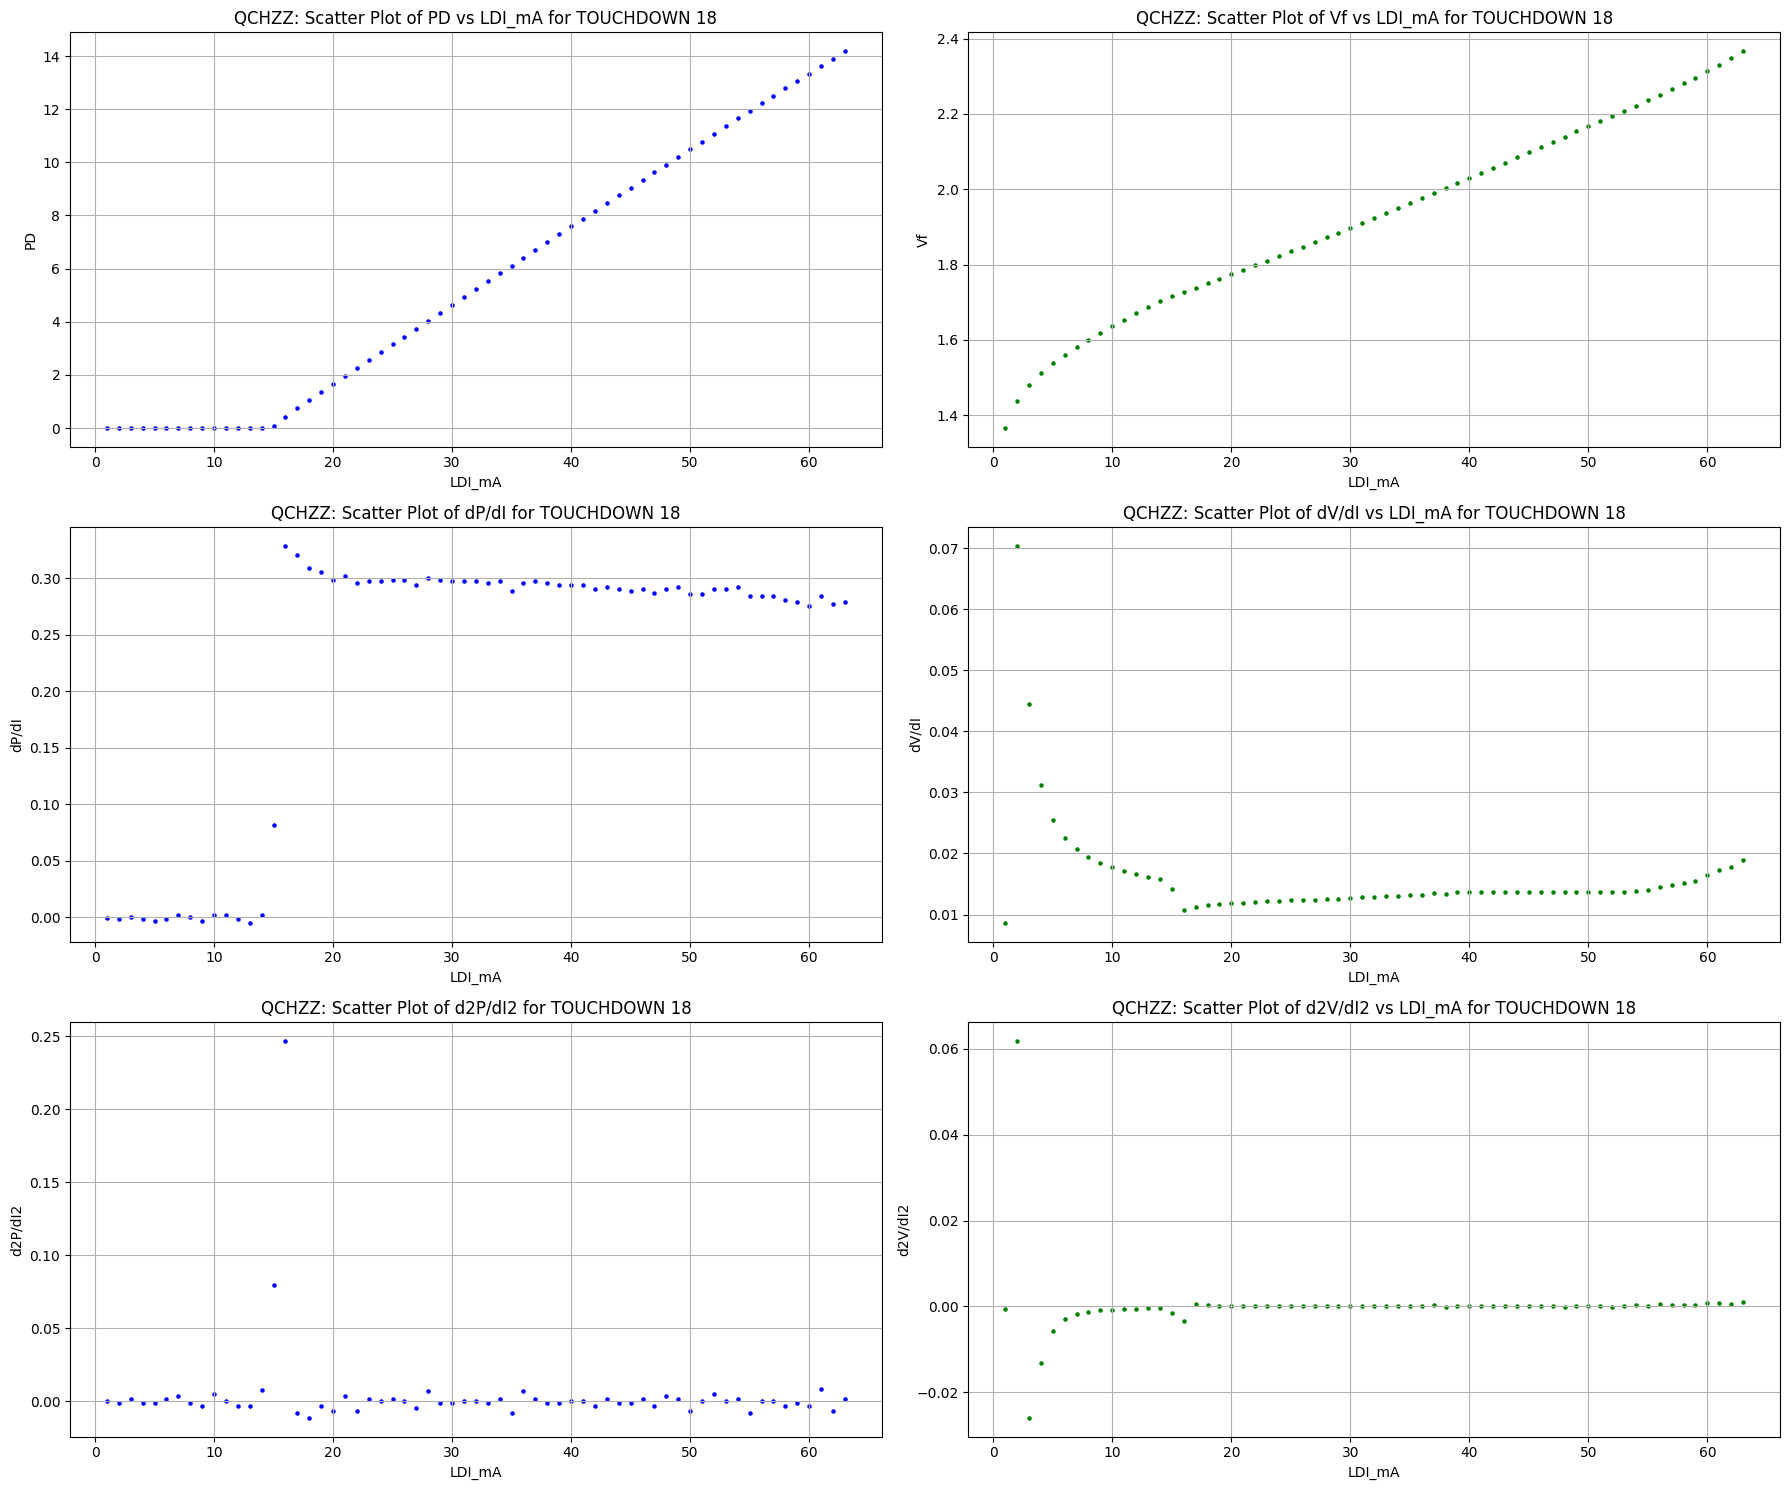

In [63]:
# Function to plot PD/LDI and Vf/LDI for a specific laser and wafer
def plot_specific_touchdown(df_raw_sweeps, wafer_code, touchdown, pnt_size):
    specific_data = df_raw_sweeps[(df_raw_sweeps["WAFER_ID"] == wafer_code) & (df_raw_sweeps["TOUCHDOWN"] == touchdown)]

    if specific_data.empty:
        print(f"No data found for Wafer Code: {wafer_code} and TOUCHDOWN: {touchdown}")
        return

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18, 15))

    # Plot PD/LDI
    ax1.scatter(specific_data["LDI_mA"], specific_data["PD"], s=pnt_size, color="blue")
    ax1.set_title(f"{wafer_code}: Scatter Plot of PD vs LDI_mA for TOUCHDOWN {touchdown}")
    ax1.set_xlabel("LDI_mA")
    ax1.set_ylabel("PD")
    ax1.grid(True)

    # Plot dP/dI
    ax3.scatter(specific_data["LDI_mA"], specific_data["dP/dI"], s=pnt_size, color="blue")
    ax3.set_title(f"{wafer_code}: Scatter Plot of dP/dI for TOUCHDOWN {touchdown}")
    ax3.set_xlabel("LDI_mA")
    ax3.set_ylabel("dP/dI")
    ax3.grid(True)

    # Plot d2P/dI2
    ax5.scatter(specific_data["LDI_mA"], specific_data["d2P/dI2"], s=pnt_size, color="blue")
    ax5.set_title(f"{wafer_code}: Scatter Plot of d2P/dI2 for TOUCHDOWN {touchdown}")
    ax5.set_xlabel("LDI_mA")
    ax5.set_ylabel("d2P/dI2")
    ax5.grid(True)

    # Plot Vf/LDI
    ax2.scatter(specific_data["LDI_mA"], specific_data["Vf"], s=pnt_size, color="green")
    ax2.set_title(f"{wafer_code}: Scatter Plot of Vf vs LDI_mA for TOUCHDOWN {touchdown}")
    ax2.set_xlabel("LDI_mA")
    ax2.set_ylabel("Vf")
    ax2.grid(True)

    # Plot dV/dI
    ax4.scatter(specific_data["LDI_mA"], specific_data["dV/dI"], s=pnt_size, color="green")
    ax4.set_title(f"{wafer_code}: Scatter Plot of dV/dI vs LDI_mA for TOUCHDOWN {touchdown}")
    ax4.set_xlabel("LDI_mA")
    ax4.set_ylabel("dV/dI")
    ax4.grid(True)

    # Plot d2V/dI2
    ax6.scatter(specific_data["LDI_mA"], specific_data["d2V/dI2"], s=pnt_size, color="green")
    ax6.set_title(f"{wafer_code}: Scatter Plot of d2V/dI2 vs LDI_mA for TOUCHDOWN {touchdown}")
    ax6.set_xlabel("LDI_mA")
    ax6.set_ylabel("d2V/dI2")
    ax6.grid(True)

    plt.tight_layout()

    plt.show()


# INPUT THE DESIRED PROFILE TO EXAMINE HERE
# Define the specific wafer code and TOUCHDOWN number
WAFER_CODE = "QCHZZ"
TOUCHDOWN = 18

# Find the correct dataframe where the wafer code matches the input
df_raw_sweeps = None
for df in annotated_sweeps_tables:
    if df["WAFER_ID"].iloc[0] == WAFER_CODE:
        df_raw_sweeps = df
        break

if df_raw_sweeps is not None:
    # Plot for the specified touchdown number
    plot_specific_touchdown(df_raw_sweeps, WAFER_CODE, TOUCHDOWN, pnt_size=5)
else:
    print(f"No data found for Wafer Code: {WAFER_CODE}")